<br>Original implementation :https://www.kaggle.com/ohmets/feature-selection-for-regression/report </br> 
<br> Paper used : http://www.iraj.in/journal/journal_file/journal_pdf/12-477-153396274234-40.pdf </br>

library 

In [25]:
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis,FastICA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

# 1. Data exploration and Preprocessing

define a function that load data and save figure

In [3]:
def load_csv_data(housing_path="data", fname="train.csv"):
    csv_file = os.path.join(housing_path,fname)
    return pd.read_csv(csv_file)

def save_fig(fig_id, fpath="images", ext="png", tight_layout=True, resolution=300):
    path = os.path.join(fpath, fig_id+'.'+ext)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=ext, dpi=resolution)

In [4]:
house_train = load_csv_data()
house_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
def reduiceDataframe(dataframe, listOfColumns):
    return dataframe[listOfColumns]

In [6]:
columnsAffectPrices = ['Id','MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt',
                      'YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
                      '2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                      'BedroomAbvGr','KitchenAbvGr', 'TotRmsAbvGrd','Fireplaces','GarageYrBlt',
                      'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF', 'EnclosedPorch','3SsnPorch',
                      'ScreenPorch', 'PoolArea','MiscVal','MoSold','YrSold', 'SalePrice'
                      ]

In [7]:
df = reduiceDataframe(house_train, columnsAffectPrices)
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [8]:
# finding out missing value
df.isnull().sum()

Id                 0
MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [9]:
def dropna_value(dataframe, axis=0, inplace=True):
    return dataframe.dropna(axis=0, inplace=True)

In [10]:
dropna_value(df)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# 2. Data Analysis

**<font color="blue">2.1. tab of correlation between features</font>**

In [11]:
def heatmap_square(dataframe):
    corr = dataframe.corr()
    corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    corr.columns = ['x', 'y', 'value']
    x = corr['x']
    y = corr['y']
    size = corr['value'].abs()
    
    fig, ax = plt.subplots(figsize=(30,30))

    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 900
    
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=np.ravel(dataframe.corr().values),
        marker='s' # Use square as scatterplot marker
    )
    
    
    # Show column labels on the axes
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    save_fig("showHowFeatureCorr")
    

In [12]:

def heatmap(dataframe):
    corr = dataframe.corr()
    corr1 = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    corr1.columns = ['x', 'y', 'value']
    x = corr1['x']
    y = corr1['y']
    size = corr1['value'].abs()
    
    fig, ax = plt.subplots(figsize=(30,30))

    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 900
    
    """ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=np.ravel(dataframe.corr().values),
        marker='s' # Use square as scatterplot marker
    )"""
    sns.heatmap(corr,annot=True)
    
    
    # Show column labels on the axes
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    save_fig("M_correlation")
    

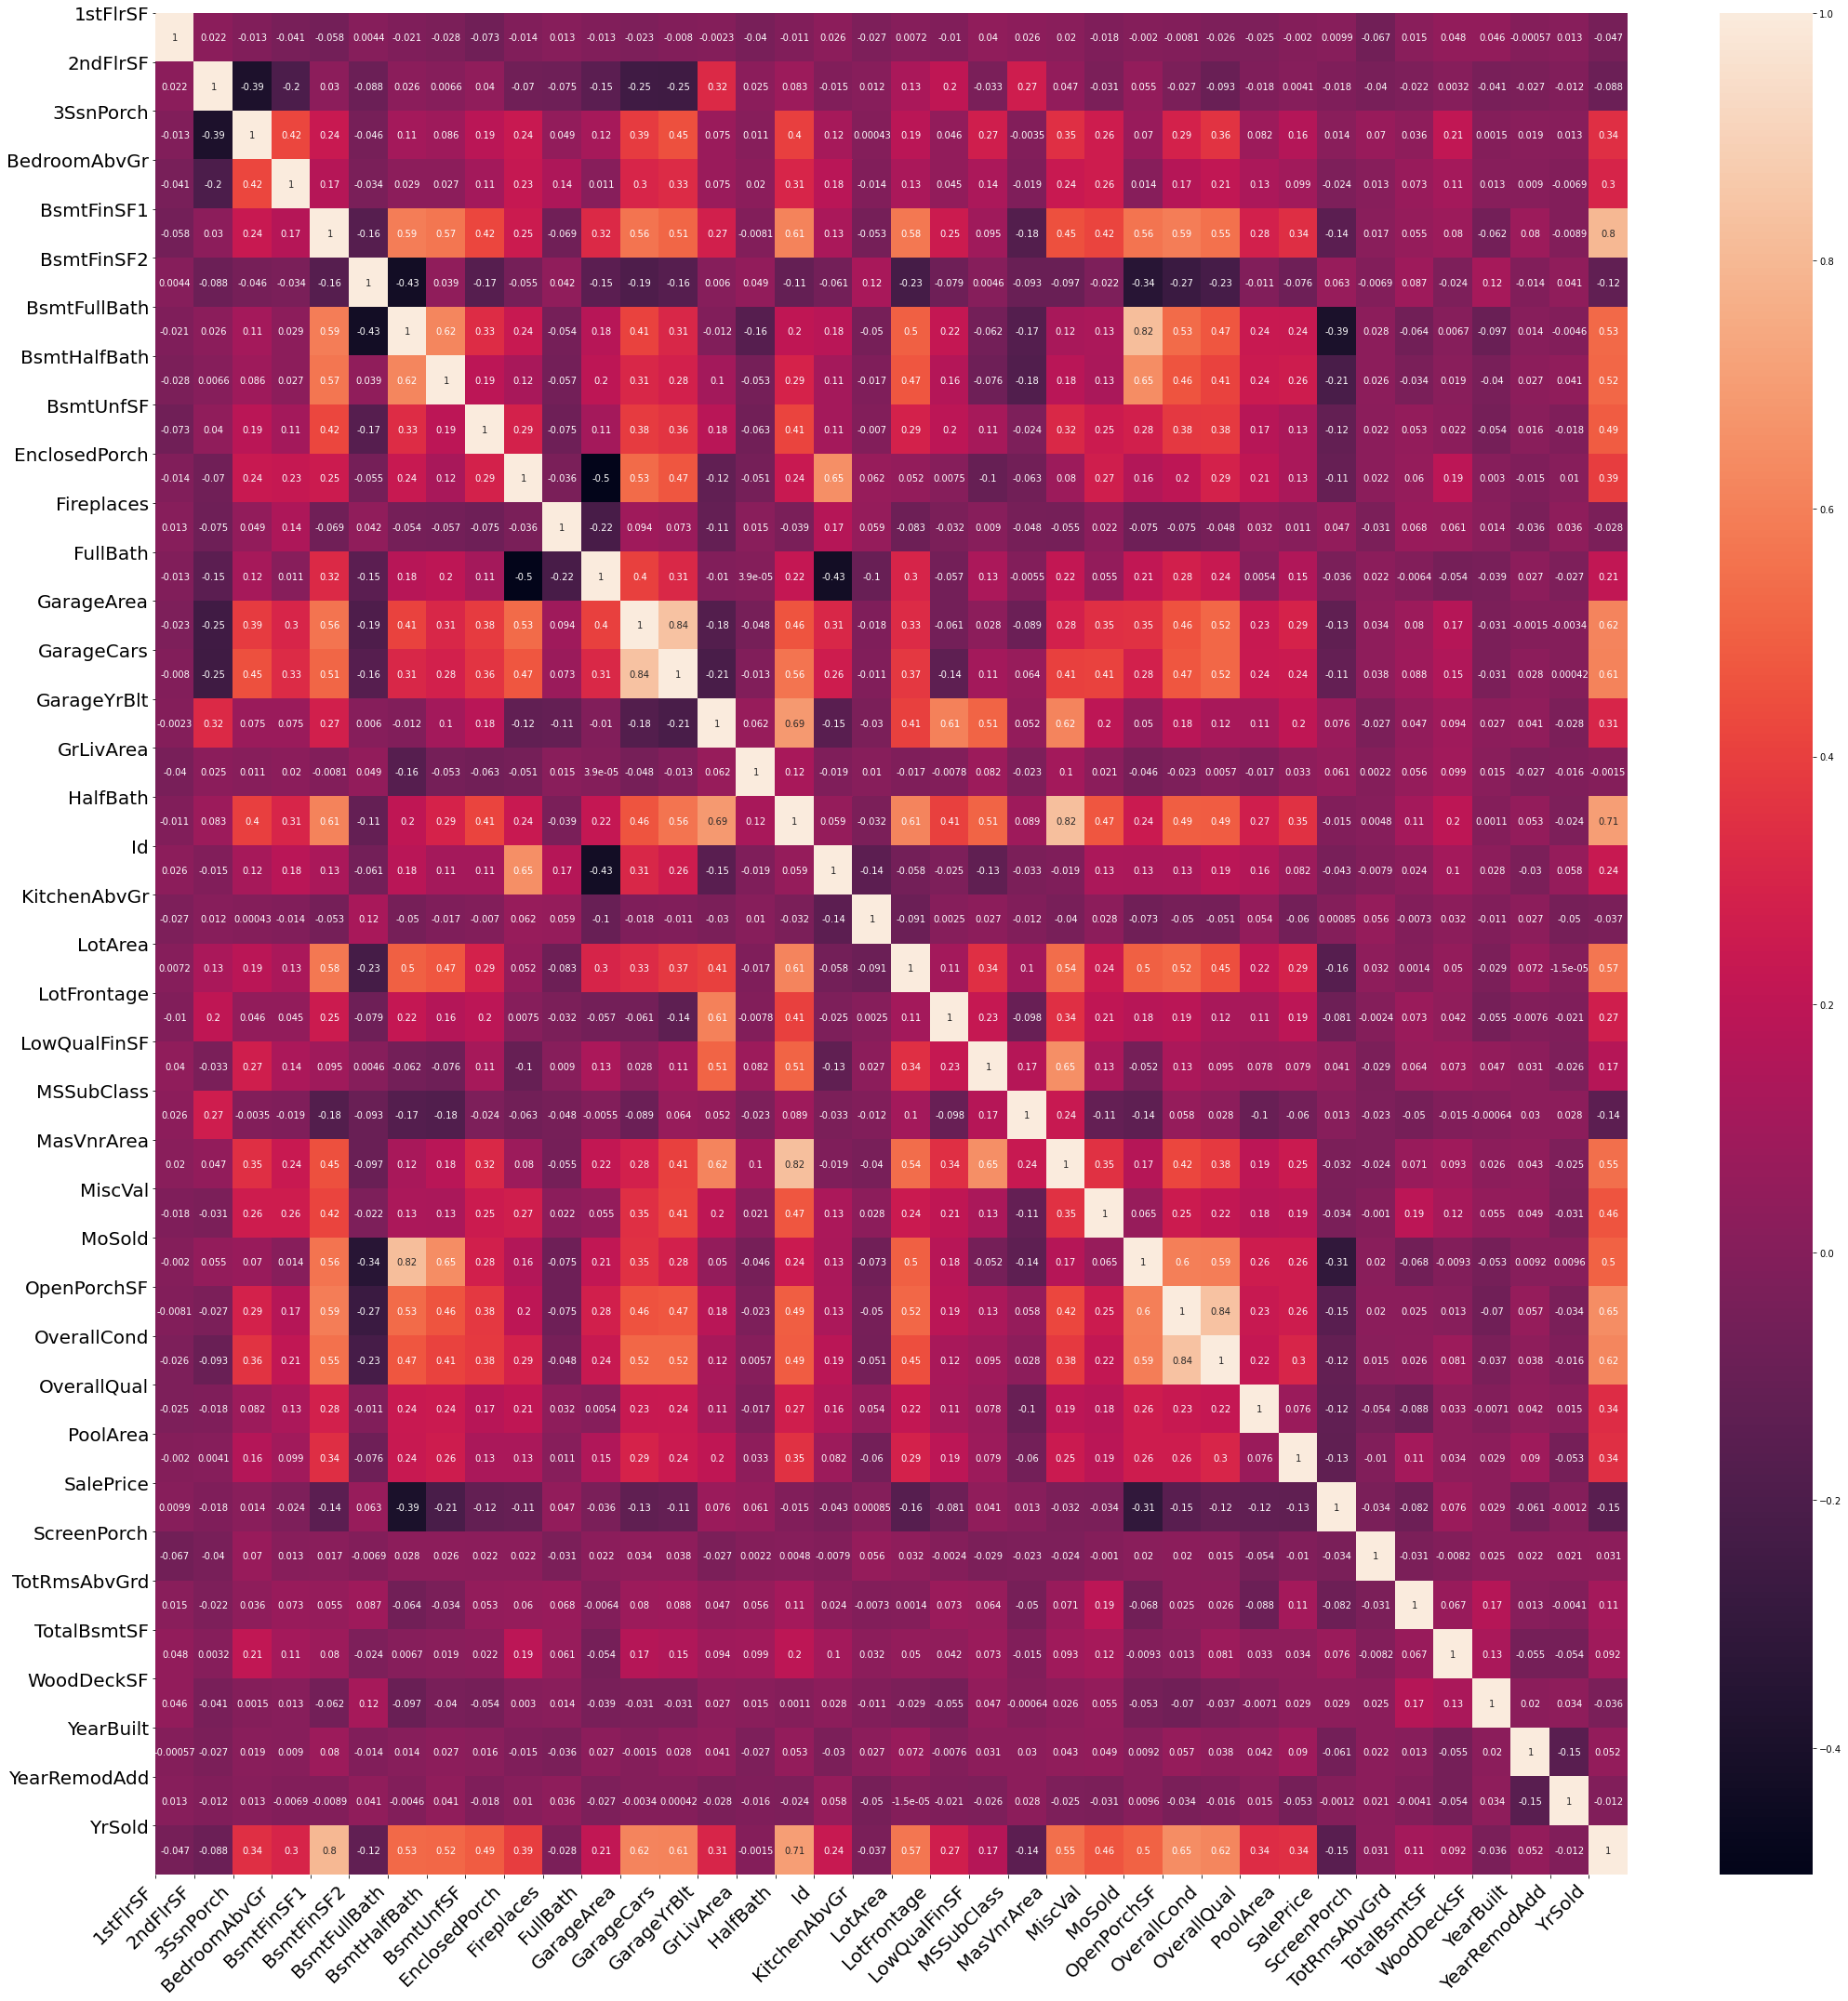

In [13]:
heatmap(df)

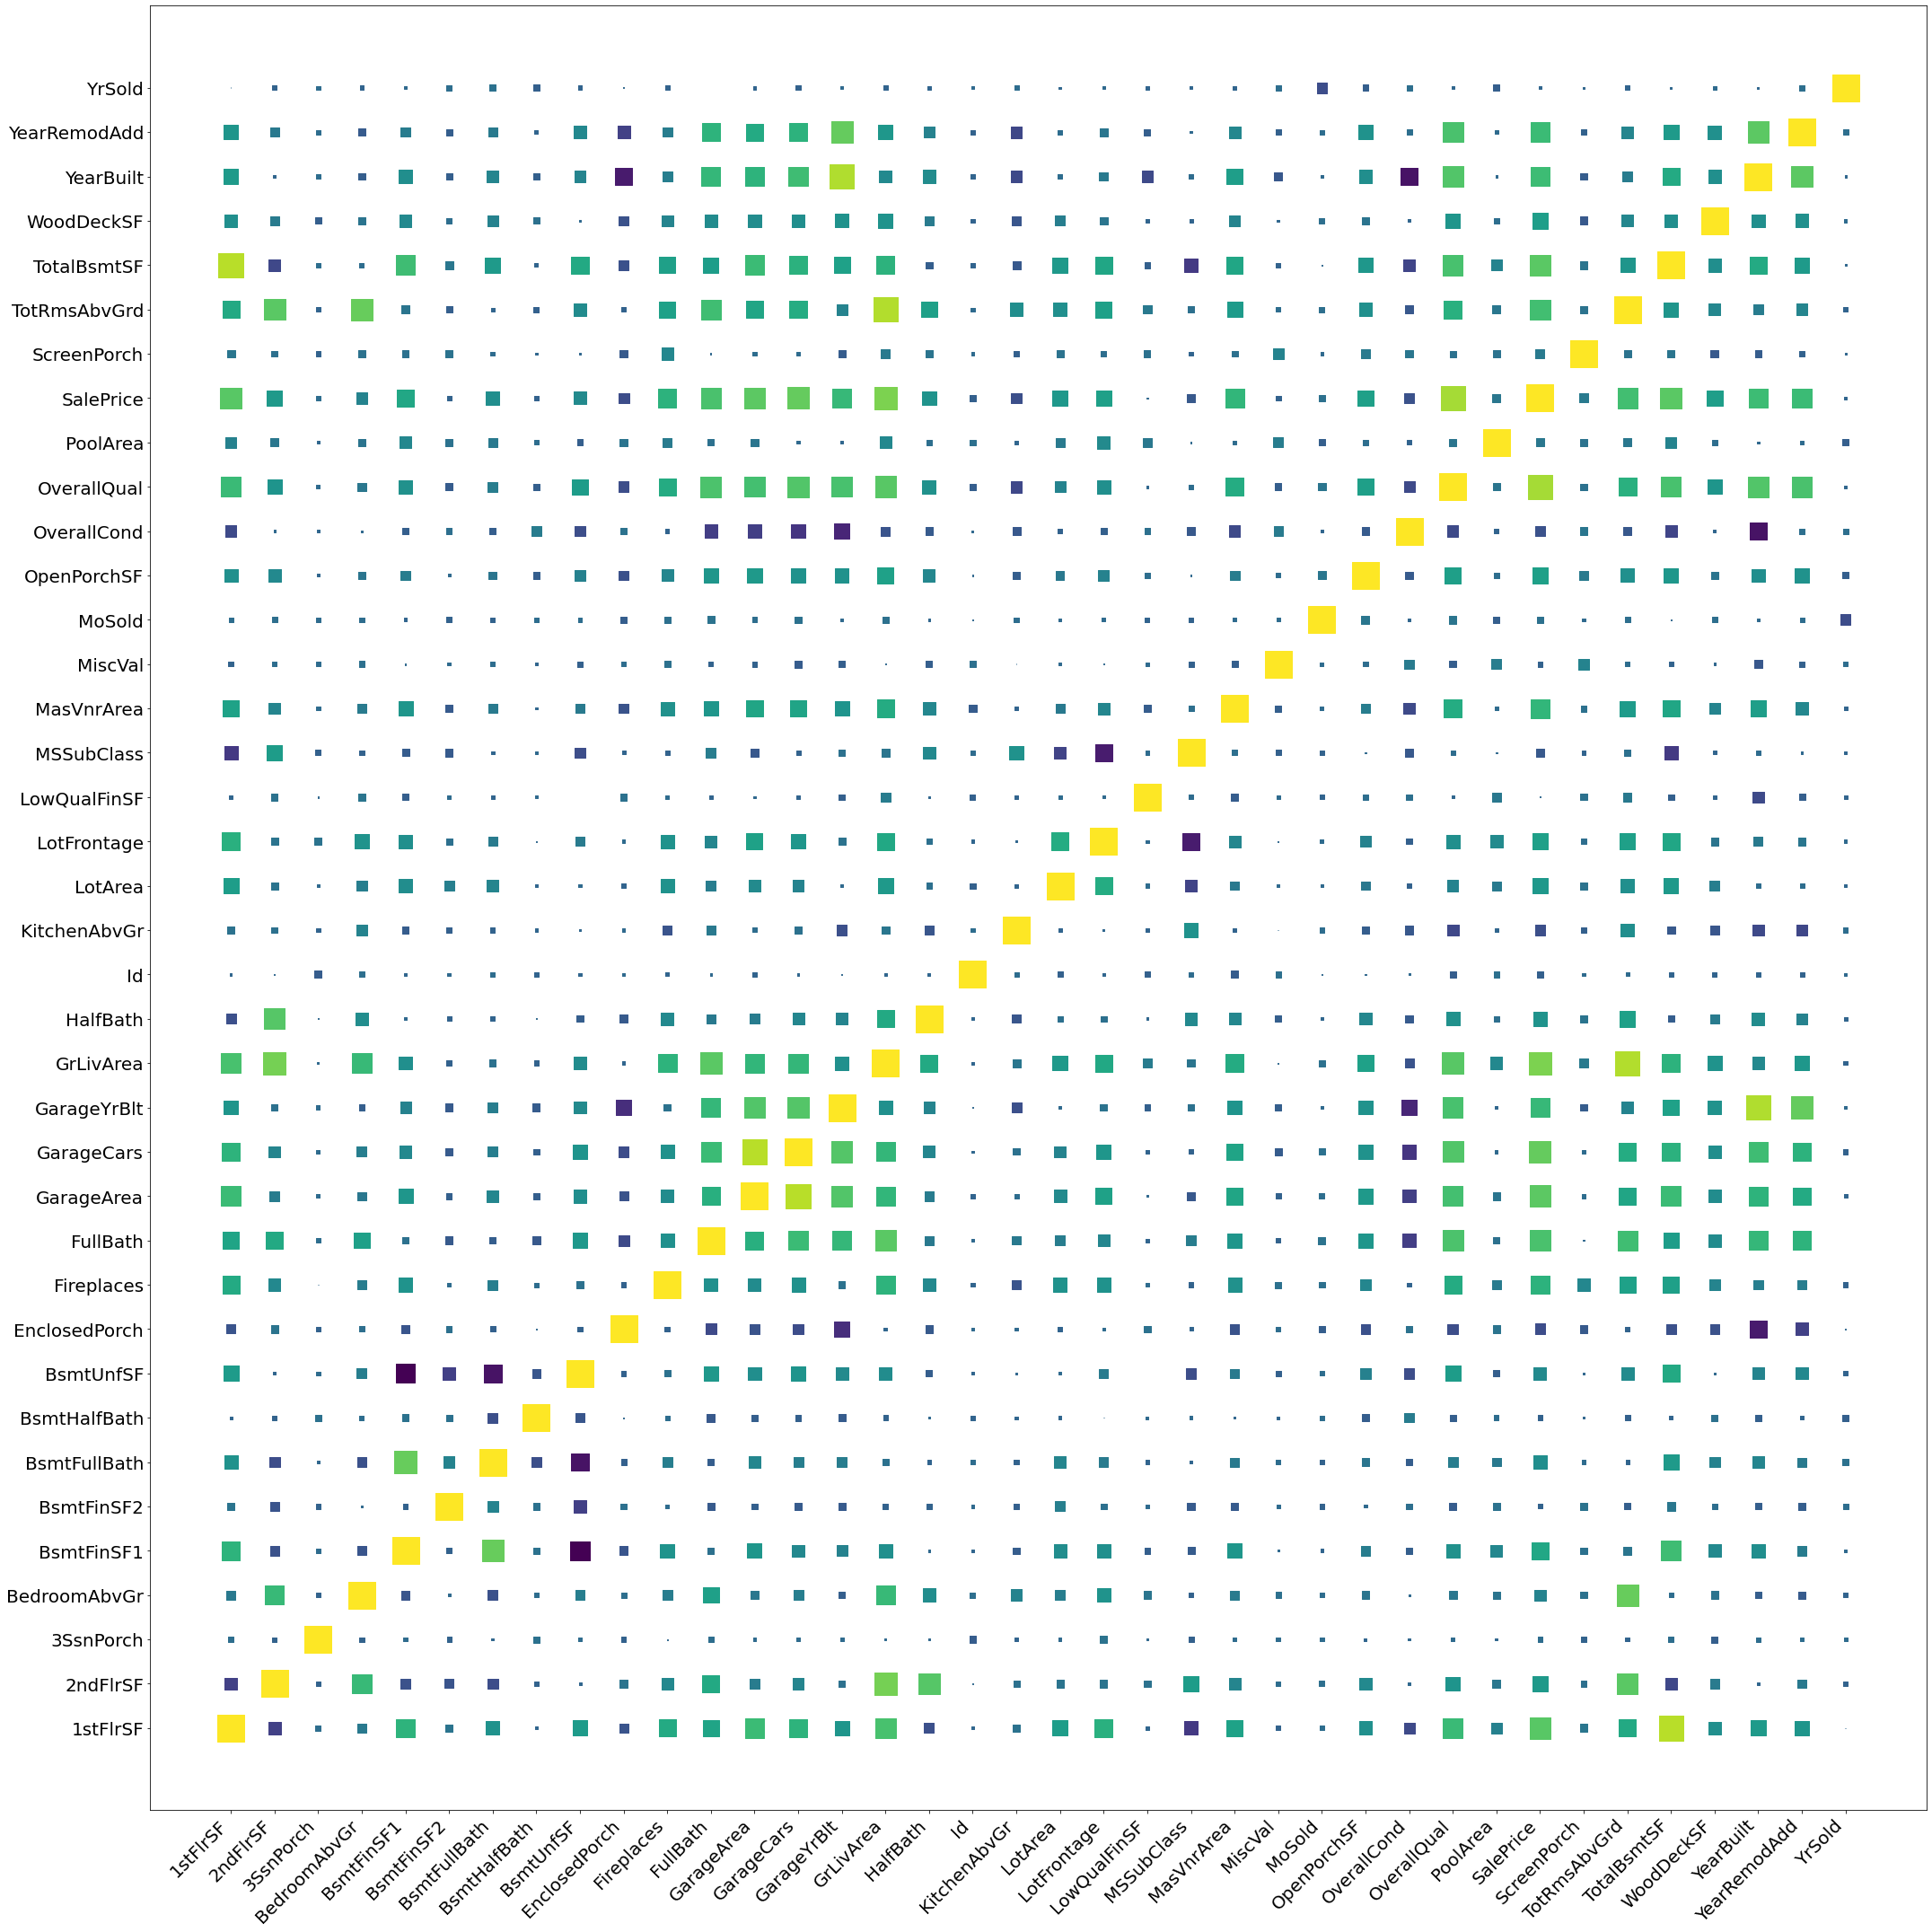

In [74]:
heatmap_square(df)

**<font color="blue">2.2. Methods for dimensionality reduction</font>**

In [162]:
DR = {'PCA':PCA, 'FactorAnalysis':FactorAnalysis, 'FastICA':FastICA}

In [161]:
# Sandardizing the features
def stdSc(dataframe):
    features = [i for i in dataframe.columns if i!='SalePrice']
    X = dataframe[features].values
    X = StandardScaler().fit_transform(X)
    y = dataframe['SalePrice'].values
    return X, y

In [163]:
def compute_eigenvalues(dataframe):
    X, _ = stdSc(dataframe)
    X = np.cov(X.T)
    eigenvalues = np.linalg.eigvals(X)
    array = np.argsort(eigenvalues)
    return eigenvalues[array][::-1]

In [230]:
# return a dataframe with dim reduce
def dim_reduction(dataframe, method='PCA', n_components=31, random_state=42):
    X, y = stdSc(dataframe)
    model = DR[method](n_components=n_components, random_state=random_state)
    array = model.fit_transform(X)
    array = np.c_[array, y]
    df = pd.DataFrame(data = array, columns=[f'component_{i+1}' for i in range(n_components)]+['SalePrice'])
    return df, model

**<font color="orange">Implement PCA</font>**

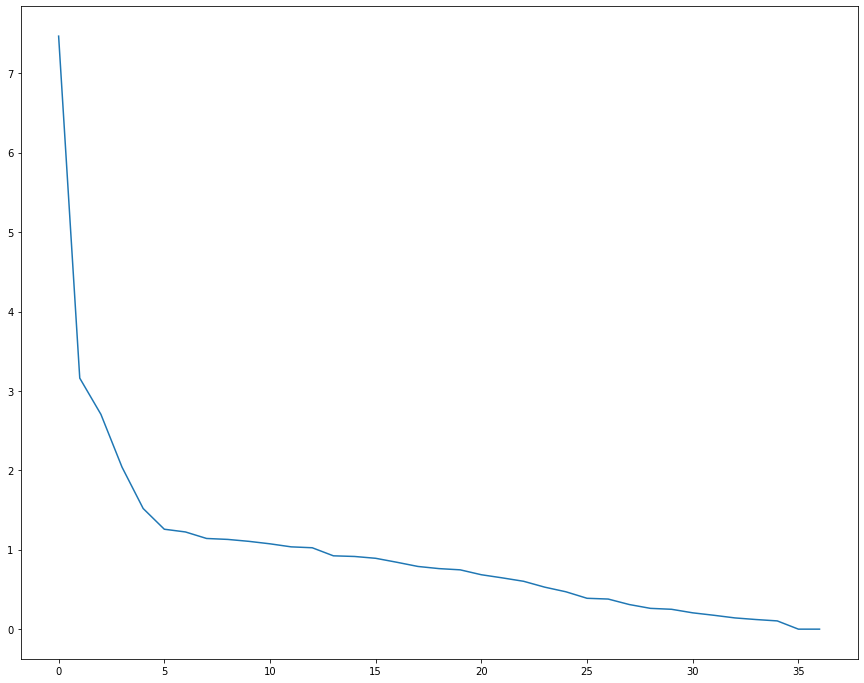

In [231]:
eigenvalues =compute_eigenvalues(df)
fig, ax = plt.subplots(figsize=(15,12))
ax.plot(eigenvalues)

***for certain x>=3, the curve decrease slownly***

In [233]:
new_df, model = dim_reduction(df)
new_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,SalePrice
0,1.296388,0.453687,-1.281729,-2.160923,0.294612,-0.619446,-1.204596,-0.925831,-0.526143,-0.798554,0.955134,0.472004,-0.365140,-0.705274,0.572757,-0.827078,1.139176,0.541071,-0.656460,-0.553864,-0.957694,0.121230,0.209056,0.484844,-0.016161,-0.350105,-0.192094,-0.692702,-0.142485,0.050295,0.134017,208500.0
1,-0.278810,-0.995142,1.206712,0.076206,-1.582557,-2.680921,1.415952,2.913255,-1.422797,1.005196,-0.086732,0.627102,1.067393,-1.253221,0.582257,-0.904887,0.742369,0.023557,-0.213372,0.506347,-1.067044,-0.918332,-0.183465,-0.658559,-0.316838,0.058279,-0.145171,0.535356,-1.119307,-0.697258,0.156233,181500.0
2,1.493136,0.343388,-1.136507,-1.553825,-0.298028,-0.624196,0.322709,-0.942368,0.211106,-0.585175,0.698110,0.279702,-0.960703,0.220202,0.802931,-0.472863,0.285286,-0.785114,0.541893,-0.646026,-0.821239,0.331295,-0.479632,0.393856,-0.167861,-0.111597,0.501056,-0.449467,-0.198028,-0.742402,0.342734,223500.0
3,-0.454315,1.101730,0.725187,-0.002642,0.965874,-0.698585,-0.837498,-2.431815,-1.806901,1.267125,-0.455183,-0.307346,-1.233405,1.479255,0.381057,-3.034113,-0.349776,1.291089,0.081555,1.106977,-1.075287,-1.295277,-0.296048,-0.104142,-0.766521,0.175769,1.009851,-0.665464,0.118300,0.995636,0.678575,140000.0
4,4.341204,1.380685,-0.322627,-1.344211,0.031196,-1.242242,0.808515,-0.224490,0.792609,-0.372529,0.463203,0.099260,-1.673855,0.014605,0.990016,-0.868072,-0.544347,-0.884480,-0.032215,-0.838586,0.223135,-0.037050,-0.191069,0.153538,-0.668767,0.210656,0.830367,-0.358186,0.030356,0.131219,-0.104476,250000.0


<h3>Explained variance ratio</h3>
<p>The explained variance tells us how much information (variance) can be attributed to
each of the principal components.</p>

In [235]:
sum(model.explained_variance_ratio_)*100

98.53934545252866

<font color="red" > Here, we keep 98.53% of the information  </font>

**<font color="orange"> Implement ICA</font>**

**<font color="orange">Implement Factorial Analysis</font>**

# 3. Modeling

**<font color="orange" >Loss</font>**

**<font color="orange">Optimizer</font>**

# 4. Training

# 5. Inference

# 6. Metrics